**RetinaNet with TensorFlow2.x**

In [ ]:
import os
import re
import zipfile

import numpy as np
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

**Downloading the COCO2017 dataset**

In [ ]:
url = "https://github.com/srihari-humbarwadi/datasets/releases/donwload/v0.1.0/data.zip"
filename = os.path.join(os.getcwd(),"data.zip")
keras.utils.get_file(filename,url)

with zipfile.Zipfile("data.zip","r") as z_fp:
  z_fp.extractall("./")

**Implementing utility functions**

In [ ]:
#Iplementing utility functions
def swap_xy(boxes):
    return tf.stack([boxes[:,1],boxes[:,0],boxes[:,3],boxes[:,2]],axis = -1)


def convert_to_xywh(boxes):
    return tf.concat(
    [(boxes[...,:2]+boxes[...,2:])/2.0,boxes[...,2:]-boxes[...,:2]],
    axis = -1,
    )

def convert_to_corners(boxes):
    return tf.concat(
    [boxes[...,:2] - boxes[...,2:]/2.0,boxes[...,:2]+boxes[...,2:]/2.0],
    axis=-1,
    )

def visualize_detections(
    image,boxes,classes,scores,figsize=(7,7),linewidth=1, color=[0,0,1]
):
    "visualize_detections"
    image = np.array(image,dtype=np.uint8)
    plt.figure(figsize=figsize)
    plt.axis("off")
    plt.imshow(image)
    ax = plt.gca()
    for box, _cls, score in zip(boxes,classes,scores):
        text = "{}: {:.2f}".format(_cls,score)
        x1,y1,x2,y2 = box
        w,h = x2-x1,y2-y1
        patch = plt.Rectangle(
            [x1,y1],w,h,fill = False, edgecolor=color,linewidth=linewidth
        )
        ax.add_patch(patch)
        ax.text(
            x1,
            y1,
            text,
            bbox={"facecolor":color,"alpha":0.4},
            clip_box=ax.clipbox,
            clip_on = True,
        )
    plt.show()
    return ax

**Computing pairwise Intersection Over Union (IOU)**

In [ ]:
#Computing pairwise over Union (IOU)
def compute_iou(boxes1, boxes2):
        
    boxes1_corners = convert_to_corners(boxes1)
    boxes2_corners = convert_to_corners(boxes2)
    lu = tf.maximum(boxes1_corners[:,None,:2],boxes2_corners[:,:2])
    rd = tf.minimum(boxes1_corners[:,None,2:],boxes2_corners[:,2:])
    intersection = tf.maximum(0.0,rd-lu)
    intersection_area = intersection[:,:,0]*intersection[:,:,1]
    boxes1_area = boxes1[:,2] * boxes1[:,3]
    boxes2_area = boxes2[:,2] * boxes2[:,3]
    union_area = tf.maximum(
        boxes1_area[:,None] + boxes2_area - intersection_area ,1e-8
    )

    return tf.clip_by_value(intersection_area / union_area,0.0,1.0)


**Implementing Anchor generator**

In [ ]:

class AnchorBox:
    #Generates anchor boxes
    
    def __init__(self):
        self.aspect_ratios = [0.5,1.0,2.0]
        self.scales = [2**x for x in [0,1/3,2/3]]

        self._num_anchors = len(self.aspect_ratios)*len(self.scales)
        self._strides = [2 ** i for i in range(3,8)]
        self._areas = [x ** 2 for x in [32.0,64.0,128.0,256.0,512.0]]
        self._anchor_dims = self._compute_dims()


    def _compute_dims(self):

        anchor_dims_all = []
        for area in self._areas:
            anchor_dims = []
            for ratio in self.aspect_ratios:
                anchor_height = tf.math.sqrt(area /ratio)
                anchor_width = area/anchor_height
                dims = tf.reshape(
                    tf.stack([anchor_width,anchor_height],axis = -1),[1,1,2]
                )
                for scale in self.scales:
                    anchor_dims.append(scale*dims)
            anchor_dims_all.append(tf.stack(anchor_dims,axis = -2))
        return anchor_dims_all


    def _get_anchors(self, feature_height, feature_width,level):

        rx = tf.range(feature_width , dtype = tf.float32) + 0.5
        ry = tf.range(feature_height, dtype=tf.float32) + 0.5
        centers = tf.stack(tf.meshgrid(rx,ry),axis=-1)*self._strides[level-3]
        centers = tf.expand_dims(centers,axis=-2)
        centers = tf.tile(centers, [1,1,self._num_anchors,1])
        dims = tf.tile(
            self._anchor_dims[level-3],[feature_height,feature_width,1,1]
        )
        anchors = tf.concat([centers,dims], axis =-1)
        return tf.reshape(
            anchors,[feature_height*feature_width*self._num_anchors,4]
            )

    def get_anchors(self,image_height,iamge_width):

        anchors = [
            self._get_anchors(
                tf.math.ceil(image_height/2**i),
                tf.math.ceil(iamge_width/2**i),
                i,
            )
            for i in range(3,8)
        ]
        return tf.concat(anchors,axis = 0)

**Preprocessing data**

In [ ]:
#Preprocessing Data

def random_flip_horizontal(image,boxes):

    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        boxes = tf.stack(
        [1 - boxes[:,2],boxes[:,1],1 - boxes[:,0],boxes[:,3]],axis=-1
        )
    return image,boxes


def resize_and_pad_image(
    image,min_side = 800.0,max_side=1333.0,jitter=[640,1024],stride = 128.0
):
    
    image_shape = tf.cast(tf.shape(image)[:2],dtype = tf.float32)
    if jitter is not None:
        min_side = tf.random.uniform((),jitter[0],jitter[1],dtype=tf.float32)
    ratio = min_side/tf.reduce_min(image_shape)
    if ratio * tf.reduce_max(image_shape) > max_side:
        ratio = max_side /tf.reduce_max(image_shape)
    image_shape = ratio * image_shape
    image = tf.image.resize(image,tf.cast(image_shape,dtype=tf.int32))
    padded_image_shape = tf.cast(
        tf.math.ceil(image_shape / stride)*stride,dtype = tf.int32
    )
    image = tf.image.pad_to_bounding_box(
        image,0,0,padded_image_shape[0],padded_image_shape[1]
    )
    return image,image_shape,ratio

def preprocess_data(sample):

    image  = sample["image"]
    bbox = swap_xy(sample["objects"]["bbox"])
    class_id = tf.cast(sample["objects"]["label"],dtype=tf.int32)

    image, bbox = random_flip_horizontal(image,bbox)
    image, image_shape, _ = resize_and_pad_image(image)

    bbox = tf.stack(
        [
            bbox[:,0] * image_shape[1],
            bbox[:,1] * image_shape[0],
            bbox[:,2] * image_shape[1],
            bbox[:,3] * image_shape[0],
        ],
        axis = -1,
    )
    bbox = convert_to_xywh(bbox)
    return image, bbox, class_id

**Encoding labels**

In [ ]:
#Encoding Labels

class LabelEncoder:
    
    def __init__(self):
        self._anchor_box= AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            [0.1, 0.1, 0.2, 0.2], dtype=tf.float32
        )
    def _match_anchor_boxes(
        self, anchor_boxes, gt_boxes,match_iou=0.5,ignore_iou=0.4
    ):
        iou_matrix = compute_iou(anchor_boxes,gt_boxes)
        max_iou = tf.reduce_max(iou_matrix,axis=1)
        matched_gt_idx = tf.argmax(iou_matrix,axis=1)
        positive_mask = tf.greater_equal(max_iou,match_iou)
        negative_mask = tf.less(max_iou,ignore_iou)
        ignore_mask = tf.logical_not(tf.logical_or(positive_mask,negative_mask))
        return (
            matched_gt_idx,
            tf.cast(positive_mask,dtype=tf.float32),
            tf.cast(ignore_mask,dtype=tf.float32),
        )

    def _compute_box_target(self,anchor_boxes,matched_gt_boxes):

        box_target = tf.concat(
            [
                (matched_gt_boxes[:,:2]-anchor_boxes[:,:2])/anchor_boxes[:,2:],
                tf.math.log(matched_gt_boxes[:,2:] /anchor_boxes[:,2:]),
            ],
            axis=-1,
        )
        box_target = box_target/self._box_variance
        return box_target

    def _encode_sample(self,image_shape,gt_boxes,cls_ids):

        anchor_boxes = self._anchor_box.get_anchors(image_shape[1],image_shape[2])
        cls_ids = tf.cast(cls_ids,dtype=tf.float32)
        matched_gt_idx,positive_mask,ignore_mask = self._match_anchor_boxes(
            anchor_boxes,gt_boxes
        )
        matched_gt_boxes = tf.gather(gt_boxes,matched_gt_idx)
        box_target = self._compute_box_target(anchor_boxes,matched_gt_boxes)
        matched_gt_cls_ids = tf.gather(cls_ids,matched_gt_idx)
        cls_target = tf.where(
            tf.not_equal(positive_mask,1.0),-1.0,matched_gt_cls_ids
        )
        cls_target = tf.where(tf.equal(ignore_mask,1.0),-2.0,cls_target)
        cls_target = tf.expand_dims(cls_target,axis=-1)
        label = tf.concat([box_target,cls_target],axis=-1)
        return label


    def encode_batch(self, batch_images,gt_boxes,cls_ids):

        image_shape = tf.shape(batch_images)
        batch_size = image_shape[0]

        labels = tf.TensorArray(dtype = tf.float32,size = batch_size,dynamic_size=True)
        for i in range(batch_size):
            label = self._encode_sample(image_shape,gt_boxes[i],cls_ids[i])
            labels = labels.write(i,label)
        batch_images = tf.keras.applications.resnet.preprocess_input(batch_images)
        return batch_images,labels.stack()


**Building the ResNet50 backbone**

In [ ]:
def get_backbone():

    backbone = keras.applications.ResNet50(
        include_top=False,input_shape=[None,None,3]
    )
    c3_output, c4_output, c5_output = [
        backbone.get_layer(layer_name).output
        for layer_name in ["conv3_block4_out","conv4_block6_out","conv5_block3_out"]
    ]
    return keras.Model(
        inputs = [backbone.inputs],outputs = [c3_output,c4_output,c5_output]
    )

**Building Feature Pyramid Network as a custom layer**

In [ ]:
#Building Feature Pyramid Network as a custom layer
class FeaturePyramid(keras.layers.Layer):

    def __init__(self,backbone=None,**kwargs):
        super(FeaturePyramid,self).__init__(name="FeaturePyramid",**kwargs)
        self.backbone = backbone if backbone else get_backbone()
        self.conv_c3_1x1 = keras.layers.Conv2D(256,1,1,"same")
        self.conv_c4_1x1 = keras.layers.Conv2D(256,1,1,"same")
        self.conv_c5_1x1 = keras.layers.Conv2D(256,1,1,"same")
        self.conv_c3_3x3 = keras.layers.Conv2D(256,3,1,"same")
        self.conv_c4_3x3 = keras.layers.Conv2D(256,3,1,"same")
        self.conv_c5_3x3 = keras.layers.Conv2D(256,3,1,"same")
        self.conv_c6_3x3 = keras.layers.Conv2D(256,3,2,"same")
        self.conv_c7_3x3 = keras.layers.Conv2D(256,3,2,"same")
        self.upsample_2x = keras.layers.UpSampling2D(2)
    def call(self,images,training = False):
        c3_output,c4_output ,c5_output = self.backbone(images,training=training)
        p3_output = self.conv_c3_1x1(c3_output)
        p4_output = self.conv_c4_1x1(c4_output)
        p5_output = self.conv_c5_1x1(c5_output)
        p4_output = p4_output + self.upsample_2x(p5_output)
        p3_output = p3_output + self.upsample_2x(p4_output)
        p3_output = self.conv_c3_3x3(p3_output)
        p4_output = self.conv_c4_3x3(p4_output)
        p5_output = self.conv_c5_3x3(p5_output)
        p6_output = self.conv_c6_3x3(c5_output)
        p7_output = self.conv_c7_3x3(tf.nn.relu(p6_output))
        return p3_output,p4_output,p5_output,p6_output,p7_output 


**Building the classification and box regression heads.**

In [ ]:
#Building the classification and box regression heads
def build_head(output_filters,bias_init):

    head = keras.Sequential([keras.Input(shape=[None,None,256])])
    kernel_init = tf.initializers.RandomNormal(0.0,0.01)
    for _ in range(4):
        head.add(
            keras.layers.Conv2D(256,3,padding="same",kernel_initializer=kernel_init)
        )
        head.add(keras.layers.ReLU())
    head.add(
        keras.layers.Conv2D(
            output_filters,
            3,
            1,
            padding="same",
            kernel_initializer=kernel_init,
            bias_initializer=bias_init,
        )
    )
    return head

**Building RetinaNet using a subclassed model**

In [ ]:
#Building Retina Net using a subclassed model
class RetinaNet(keras.Model):

    def __init__(self,num_classes,backbone=None,**kwargs):
        super(RetinaNet,self).__init__(name="RetinaNet",**kwargs)
        self.fpn = FeaturePyramid(backbone)
        self.num_classes = num_classes

        prior_probability = tf.constant_initializer(-np.log((1-0.01)/0.01))
        self.cls_head = build_head(9 * num_classes,prior_probability)
        self.box_head = build_head(9*4,"zeros")

    def call(self, image,training = False):
        features = self.fpn(image,training=training)
        N = tf.shape(image)[0]
        cls_outputs = []
        box_outputs = []
        for feature in features:
            box_outputs.append(tf.reshape(self.box_head(feature),[N,-1,4]))
            cls_outputs.append(
                tf.reshape(self.cls_head(feature),[N,-1,self.num_classes])
            )

        cls_outputs = tf.concat(cls_outputs,axis=1)
        box_outputs = tf.concat(box_outputs,axis=1)
        return tf.concat([box_outputs,cls_outputs],axis=-1)

**Implementing a custom layer to decode predictions **

In [ ]:
#Implementing a custom layer to decode predicitions
class DecodePredictions(tf.keras.layers.Layer):

    def __init__(
        self,
        num_classes=80,
        confidence_threshold = 0.05,
        nms_iou_threshold = 0.5,
        max_detections_per_class=100,
        max_detections = 100,
        box_variance=[0.1,0.1,0.2,0.2],
        **kwargs
    ):

        super(DecodePredictions,self).__init__(**kwargs)
        self.num_classes = num_classes
        self.confidence_threshold = confidence_threshold
        self.nms_iou_threshold = nms_iou_threshold
        self.max_detections_per_class = max_detections_per_class
        self.max_detections = max_detections

        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            [0.1,0.1,0.2,0.2],dtype = tf.float32
        )

    def _decode_box_predictions(self,anchor_boxes,box_predictions):
        boxes = box_predictions * self._box_variance
        boxes = tf.concat(
            [
                boxes[:,:,:2]*anchor_boxes[:,:,2:]+anchor_boxes[:,:,:2],
                tf.math.exp(boxes[:,:,2:])*anchor_boxes[:,:,2:],
            ],
            axis=-1,
        )
        boxes_transformed = convert_to_corners(boxes)
        return boxes_transformed

    def call(self,images,predictions):
        image_shape = tf.cast(tf.shape(images),dtype=tf.float32)
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1],image_shape[2])
        box_predictions = predictions[:,:,:4]
        cls_predictions = tf.nn.sigmoid(predictions[:,:,4:])
        boxes = self._decode_box_predictions(anchor_boxes[None, ...],box_predictions)

        return tf.image.combined_non_max_suppression(
            tf.expand_dims(boxes,axis=2),
            cls_predictions,
            self.max_detections_per_class,
            self.max_detections,
            self.nms_iou_threshold,
            self.confidence_threshold,
            clip_boxes=False,
        )

**Implementing Smooth L1 loss and Focal Loss as Keras custom losses**

In [ ]:
#Implementing Smooth L1 loss and Focal Loss as Keras custom losses
class RetinaNetBoxLoss(tf.losses.Loss):

    def __init__(self,delta):
        super(RetinaNetBoxLoss,self).__init__(
            reduction="none",name="RetinaNetBoxLoss"
        )
        self._delta=delta
        
    def call(self,y_true,y_pred):
        difference = y_true - y_pred
        absolute_difference = tf.abs(difference)
        squared_difference = difference**2
        loss = tf.where(
            tf.less(absolute_difference,self._delta),
            0.5 * squared_difference,
            absolute_difference-0.5,
        )
        return tf.reduce_sum(loss,axis=-1)

class RetinaNetClassificationLoss(tf.losses.Loss):

    def __init__(self,alpha,gamma):
        super(RetinaNetClassificationLoss,self).__init__(
            reduction = "none",name="RetinaNetClassificationLoss"
        )
        self._alpha = alpha 
        self._gamma = gamma
        
    def call(self,y_true,y_pred):
        cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(
            labels=y_true,logits=y_pred
        )
        probs = tf.nn.sigmoid(y_pred)
        alpha = tf.where(tf.equal(y_true,1.0),self._alpha,(1.0-self._alpha))
        pt = tf.where(tf.equal(y_true,1.0), probs ,1 - probs)
        loss = alpha * tf.pow(1.0 -  pt,self._gamma) * cross_entropy
        return tf.reduce_sum(loss,axis=-1)

class RetinaNetLoss(tf.losses.Loss):

    def __init__(self,num_classes=80,alpha=0.25,gamma=2.0,delta=1.0):
        super(RetinaNetLoss,self).__init__(reduction="auto",name="RetinaNetLoss")
        self._clf_loss = RetinaNetClassificationLoss(alpha,gamma)
        self._box_loss = RetinaNetBoxLoss(delta)
        self._num_classes = num_classes

    def call(self,y_true,y_pred):
        y_pred = tf.cast(y_pred,dtype=tf.float32)
        box_labels = y_true[:,:,:4]
        box_predictions = y_pred[:,:,:4]
        cls_labels = tf.one_hot(
            tf.cast(y_true[:,:,4],dtype =tf.int32),
            depth=self._num_classes,
            dtype=tf.float32,
        )
        cls_predictions = y_pred[:,:,4:]
        positive_mask = tf.cast(tf.greater(y_true[:,:,4],-1.0),dtype=tf.float32)
        ignore_mask = tf.cast(tf.equal(y_true[:,:,4],-2.0),dtype=tf.float32)
        clf_loss = self._clf_loss(cls_labels,cls_predictions)
        box_loss = self._box_loss(box_labels,box_predictions)
        clf_loss = tf.where(tf.equal(ignore_mask,1.0),0.0,clf_loss)
        box_loss = tf.where(tf.equal(positive_mask,1.0),box_loss,0.0)
        normalizer = tf.reduce_sum(positive_mask,axis=-1)
        clf_loss = tf.math.divide_no_nan(tf.reduce_sum(clf_loss,axis=-1),normalizer)
        box_loss = tf.math.divide_no_nan(tf.reduce_sum(box_loss,axis=-1),normalizer)
        loss = clf_loss + box_loss
        return loss


**Setting up training parameters**

In [ ]:
#Setting up training parameters
model_dir = "retinanet/"
label_encoder = LabelEncoder()

num_classes = 80
batch_size = 2

learning_rates = [2.5e-06,0.000625,0.00125,0.0025,0.00025,2.5e-05]
learning_rate_boundaries = [124,240,500,240000,360000]
learning_rate_fn = tf.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=learning_rate_boundaries,values=learning_rates
)

**Initializing and compiling models**

In [ ]:
#Initializing and compiling model
resnet50_backbone = get_backbone()
loss_fn = RetinaNetLoss(num_classes)
model = RetinaNet(num_classes,resnet50_backbone)

optimizer = tf.optimizers.SGD(learning_rate = learning_rate_fn,momentum=0.9)
model.compile(loss=loss_fn,optimizer=optimizer)

**Setting up callbacks**

In [ ]:
#Setting up callbacks
callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(model_dir,"weights"+"_epoch_{epoch}"),
        monitor="loss",
        save_best_only= False,
        save_weights_only=True,
        verbose=1,
    )
]

**Load the COCO2017 dataset using TensorFlow Datasets**

In [ ]:
#Load the COCO2017 dataset using TensorFlow Datasets
(train_dataset,val_dataset),dataset_info = tfds.load(
    "coco/2017",split=["train","validation"],with_info=True,data_dir="data"
)


**Setting up a tf.data pipeline**

In [ ]:
#Setting up  a tf.data pipeline
autotune = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.map(preprocess_data,num_parallel_calls=autotune)
train_dataset = train_dataset.shuffle(8 * batch_size)
train_dataset = train_dataset.padded_batch(
    batch_size = batch_size,padding_values=(0.0,1e-8,-1),drop_remainder=True
)
train_dataset = train_dataset.map(
    label_encoder.encode_batch,num_parallel_calls=autotune
)
train_dataset = train_dataset.apply(tf.data.experimental.ignore_errors())
train_dataset = train_dataset.prefetch(autotune)

val_dataset = val_dataset.map(preprocess_data,num_parallel_calls=autotune)
val_dataset = val_dataset.padded_batch(
    batch_size =1,padding_values=(0.0,1e-8,-1),drop_remainder=True)

val_dataset = val_dataset.map(label_encoder.encode_batch,num_parallel_calls=autotune)
val_dataset = val_dataset.apply(tf.data.experimental.ignore_errors())
val_dataset = val_dataset.prefetch(autotune)

**Training the model**

In [ ]:
#Training the model
epochs = 1
 
model.fit(
    train_dataset.take(10),
    validation_data = val_dataset.take(5),
    epochs = epochs,
    callbacks = callbacks_list,
    verbose = 1,
)

10/10 [==============================] - ETA: 0s - loss: 4.020 - ETA: 7:59 - loss: 4.043 - ETA: 7:48 - loss: 4.092 - ETA: 8:56 - loss: 4.060 - ETA: 10:26 - loss: 4.12 - ETA: 7:56 - loss: 4.0946 - ETA: 5:29 - loss: 4.100 - ETA: 3:26 - loss: 4.082 - ETA: 1:37 - loss: 4.087 - ETA: 0s - loss: 4.0922  
Epoch 00001: saving model to retinanet/weights_epoch_1
10/10 [==============================] - 1364s 136s/step - loss: 4.0922 - val_loss: 3.9527


**Loading Weights**

In [ ]:
#change this to 'model_dir' when not using the downloaded weights

weights_dir = "data"

latest_checkpoint = tf.train.latest_checkpoint(weights_dir)
model.load_weights(latest_checkpoint)

**Building inference model**

In [ ]:

image = tf.keras.Input(shape=[None,None,3],name="image")
predictions = model(image,training=False)
detections = DecodePredictions(confidence_threshold=0.5)(image,predictions)
inference_model = tf.keras.Model(inputs=image,outputs = detections)


**Generating Detections**

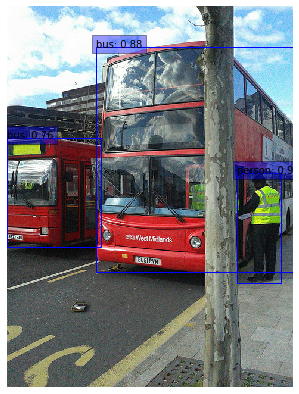

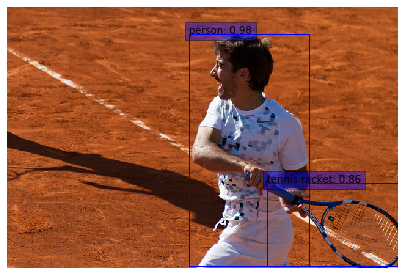

In [ ]:
#Generating detections

def prepare_image(image):
    image, _,ratio = resize_and_pad_image(image,jitter=None)
    image = tf.keras.applications.resnet.preprocess_input(image)
    return tf.expand_dims(image,axis=0),ratio

val_dataset = tfds.load("coco/2017",split="validation", data_dir="data")
int2str = dataset_info.features["objects"]["label"].int2str

for sample in val_dataset.take(2):
    image = tf.cast(sample["image"], dtype=tf.float32)
    input_image, ratio = prepare_image(image)
    detections = inference_model.predict(input_image)
    num_detections = detections.valid_detections[0]

    class_names = [
        int2str(int(x)) for x in detections.nmsed_classes[0][:num_detections]
    ]
    visualize_detections(
        image,
        detections.nmsed_boxes[0][:num_detections]/ratio,
        class_names,
        detections.nmsed_scores[0][:num_detections],
    )